# LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro

import pandas as pd

from zzz_utils import *
from lda import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(123)

## LDA model

First we simulate a toy dataset to render the Pyro models.

In [2]:
nTopics = 3    # Topics
nCells = 50    # Cells
nRegions = 100 # Regions
N = [30] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = [1] * nTopics, b = [1] * nRegions)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of nCounts x nCells, and here we assume that nCounts is the same across cells.

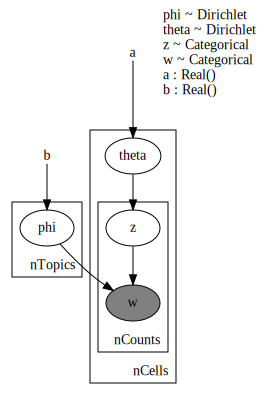

In [3]:
pyro.clear_param_store()
pyro.render_model(lda_model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

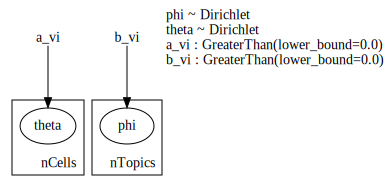

In [4]:
pyro.clear_param_store()
pyro.render_model(lda_guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

# Testing variational inference

## Simulate data
We use simulated data from the LDA model to test the amortized LDA inference performance. 
I.e. how close are inferred values to true values used to simulate the data. 

__Note__ there is the known identifiability issue of mixture and mixed-membership models, however we still would expect cell assignments to be consistent with the simulated data.


In [5]:
# Simulate data
nTopics = 2    # Topics
nCells = 1000    # Cells
nRegions = 200 # Regions
N = [100] * nCells # Cells size
a = [1/5] * nTopics
b = [1/10] * nRegions
# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

In [6]:
D.shape # simulated data dims nCounts x nCells

torch.Size([100, 1000])

In [7]:
obj['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

array([[9.94835815e-01, 5.16418480e-03],
       [2.54573180e-02, 9.74542682e-01],
       [5.20898175e-01, 4.79101825e-01],
       [9.27515786e-02, 9.07248421e-01],
       [7.18822213e-02, 9.28117779e-01],
       [8.53590854e-09, 9.99999991e-01],
       [3.24913217e-03, 9.96750868e-01],
       [9.82831644e-01, 1.71683556e-02],
       [9.15326830e-01, 8.46731699e-02]])

In [8]:
obj['phi_true'][:, 1:10].transpose() # first 10 region-topic probs

array([[1.91084158e-07, 6.11895776e-02],
       [3.75693196e-04, 2.15134890e-12],
       [4.91408046e-05, 8.73125012e-05],
       [1.48708395e-05, 1.37237615e-05],
       [6.67460884e-02, 8.78986552e-07],
       [5.73290946e-02, 4.29116237e-04],
       [8.52221386e-06, 1.35494031e-08],
       [5.11864062e-03, 1.81785633e-04],
       [1.84437999e-10, 4.79125077e-14]])

## Fit LDA 

To perform inference for Amortized LDA with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [9]:
pyro.clear_param_store()

obj = fit_lda(D = D, nTopics = nTopics, nRegions = nRegions, nSteps = 1000, lr = 0.01, seed = 123)

    18796 ----------------------------------------
    18797 Fitting 1000 cells
    18797 Step	Loss
    19084     0	562266.0
    36766   100	466583.84375
    54478   200	428612.40625
    72147   300	419910.90625
    89871   400	416300.0625
   108038   500	415336.21875
   125652   600	414471.9375
   144503   700	412136.90625
   165463   800	412228.84375
   185236   900	411415.5625
   202950 final loss = 410149.21875


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

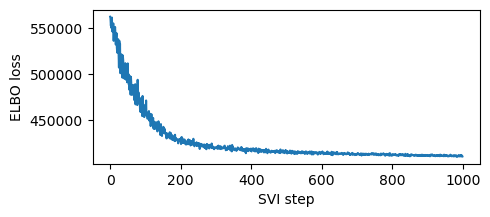

In [10]:
# plot ELBO losses
losses = obj['losses']

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [11]:
# A single sample from the guide
post_sample = lda_guide(D = D, nTopics = nTopics, nRegions = nRegions)

In [12]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.4846, 0.5154],
        [0.4710, 0.5290],
        [0.1830, 0.8170],
        [0.6137, 0.3863],
        [0.3436, 0.6564],
        [0.3821, 0.6179],
        [0.5868, 0.4132],
        [0.4640, 0.5360],
        [0.6059, 0.3941]], grad_fn=<SliceBackward0>)

In [13]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

array([[2.56093442e-02, 2.74588335e-02],
       [2.21360053e-04, 1.39813728e-05],
       [6.47219031e-06, 6.62189586e-06],
       [1.39730155e-05, 1.69293503e-11],
       [2.19957605e-02, 2.36199349e-02],
       [3.07145640e-02, 3.49883363e-02],
       [9.04992530e-32, 1.44161714e-08],
       [1.32333790e-03, 4.67479322e-03],
       [9.22284472e-22, 3.28256817e-08]], dtype=float32)